<a href="https://colab.research.google.com/github/FelipeFujinami/Python-Introduction/blob/main/Hackathon_FelipeFujinami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

In [14]:
%pip install ucimlrepo

In [16]:
%matplotlib inline
sns.set_style('darkgrid')

# **Análise Inicial**

In [17]:
heart_disease = fetch_ucirepo(id=45)

x = heart_disease.data.features
y = heart_disease.data.targets

df = pd.concat([x, y], axis=1)

print("Dimensões do dataset:", df.shape)
df.head()

Dimensões do dataset: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


# **Análise Exploratória e Preparação dos Dados**

In [18]:
# Inspeção Inicial e estatísticas descritivas
print(df.info())
print("\nEstatísticas Descritivas:")
print(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None

Estatísticas Descritivas:
          count        mean        std    min    25%    50%    75%    max
age       303.0   54.438944   9.038662   29.0   48.0   56.0   61.0   77.0
sex       303.0    0.679868   0.467299 

In [19]:
# Tratamento de valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

Valores ausentes por coluna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [20]:
# Tratamento utilizado: Imputação pela mediana
for col in df.columns:
  if df[col].isnull().any():
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

print("\nVerificação de valores ausentes após tratamento:")
print(df.isnull().sum().any())


Verificação de valores ausentes após tratamento:
False


/tmp/ipython-input-3466895095.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)



Distribuição da variável alvo:
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


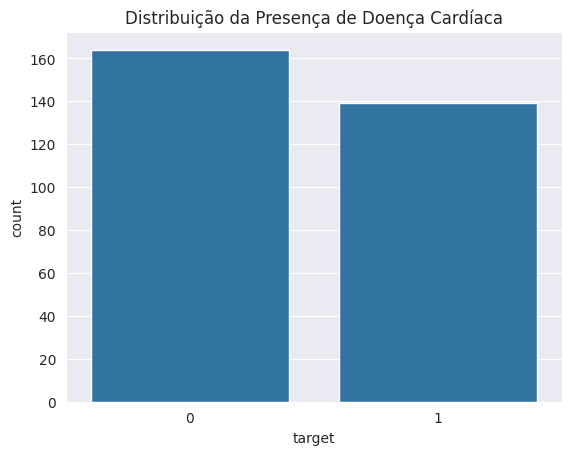

In [22]:
# Preparação da variável alvo (Target)

df['target'] = (df['num'] > 0).astype(int)
df.drop('num', axis=1, inplace=True)
print("\nDistribuição da variável alvo:")
print(df['target'].value_counts(normalize=True))

sns.countplot(x='target', data=df)
plt.title('Distribuição da Presença de Doença Cardíaca')
plt.show()

In [23]:
# Identificar colunas categóricas a serem transformadas
categorical_cols = ['cp', 'restecg', 'slope', 'thal']

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nNovas dimensões do dataset após One-Hot Encoding:", df_encoded.shape)
df_encoded.head()


Novas dimensões do dataset após One-Hot Encoding: (303, 19)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_2,cp_3,cp_4,restecg_1,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0
0,63,1,145,233,1,150,0,2.3,0.0,0,False,False,False,False,True,False,True,True,False
1,67,1,160,286,0,108,1,1.5,3.0,1,False,False,True,False,True,True,False,False,False
2,67,1,120,229,0,129,1,2.6,2.0,1,False,False,True,False,True,True,False,False,True
3,37,1,130,250,0,187,0,3.5,0.0,0,False,True,False,False,False,False,True,False,False
4,41,0,130,204,0,172,0,1.4,0.0,0,True,False,False,False,True,False,False,False,False


# **Engenharia de atributos**

In [24]:
# Agrupamento de idade por faixas
bins = [28, 40, 55, 65, 80]
labels = ['Jovem Adulto', 'Meia Idade', 'Idoso', 'Muito Idoso']
df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=bins, labels=labels, right=False)
# Converter a nova coluna categórica para one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=['age_group'], drop_first=True)


# Razão entre pressão arterial e colesterol
df_encoded['bp_chol_ratio'] = df_encoded['trestbps'] / (df_encoded['chol'] + 1e-6)

# Índice de estresse cardíaco
df_encoded['hr_stress_index'] = df_encoded['thalach'] / (1 + df_encoded['oldpeak'])

print("\nDataset com novos atributos:")
df_encoded.head()


Dataset com novos atributos:


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0,age_group_Meia Idade,age_group_Idoso,age_group_Muito Idoso,bp_chol_ratio,hr_stress_index
0,63,1,145,233,1,150,0,2.3,0.0,0,...,True,False,True,True,False,False,True,False,0.622318,45.454545
1,67,1,160,286,0,108,1,1.5,3.0,1,...,True,True,False,False,False,False,False,True,0.559441,43.200000
2,67,1,120,229,0,129,1,2.6,2.0,1,...,True,True,False,False,True,False,False,True,0.524017,35.833333
3,37,1,130,250,0,187,0,3.5,0.0,0,...,False,False,True,False,False,False,False,False,0.520000,41.555556
4,41,0,130,204,0,172,0,1.4,0.0,0,...,True,False,False,False,False,True,False,False,0.637255,71.666667


# **Construção e ajuste de modelos**

In [25]:
# Separar features (X) e target (y) novamente
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Escalar apenas as features originais contínuas para consistência
cols_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'bp_chol_ratio', 'hr_stress_index']
scaler = StandardScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Dimensões de treino:", X_train.shape)
print("Dimensões de teste:", X_test.shape)

Dimensões de treino: (227, 23)
Dimensões de teste: (76, 23)


In [28]:
from sklearn.metrics import roc_auc_score

def train_evaluate_model(model, X_train, y_train, X_test, y_test):

    # Treinamento
    model.fit(X_train, y_train)

    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Métricas de Treino
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'F1-Score': f1_score(y_train, y_train_pred),
        'AUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    }

    # Métricas de Teste
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'AUC': roc_auc_score(y_test, y_test_proba)
    }

    return train_metrics, test_metrics

# Modelo 1: Base (n_estimators=100, max_depth=None) --
print("--- Modelo 1: Baseline ---")
rf_model_1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
train_metrics_1, test_metrics_1 = train_evaluate_model(rf_model_1, X_train, y_train, X_test, y_test)

print("Métricas de Treino:", train_metrics_1)
print("Métricas de Teste:", test_metrics_1)
print("Discussão: O modelo atinge 100% nas métricas de treino (AUC=1.0), indicando sobreajuste total. O desempenho em teste é bom, mas a diferença mostra que ele decorou os dados de treino.")
print("-" * 30)


# Modelo 2: Profundo e com Mais Árvores (n_estimators=500, max_depth=20, min_samples_leaf=1) --
print("\n--- Modelo 2: Profundo e Complexo ---")
rf_model_2 = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=1, random_state=42, n_jobs=-1)
train_metrics_2, test_metrics_2 = train_evaluate_model(rf_model_2, X_train, y_train, X_test, y_test)

print("Métricas de Treino:", train_metrics_2)
print("Métricas de Teste:", test_metrics_2)
print("Discussão: Similar ao Modelo 1. Aumentar as árvores e manter a profundidade não resolveu o sobreajuste, pois cada árvore ainda pode crescer demais e memorizar os dados.")
print("-" * 30)


# Modelo 3: Regularizado e Balanceado (n_estimators=300, max_depth=10, min_samples_leaf=5, class_weight='balanced') --
print("\n--- Modelo 3: Regularizado e Balanceado ---")
rf_model_3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
train_metrics_3, test_metrics_3 = train_evaluate_model(rf_model_3, X_train, y_train, X_test, y_test)

print("Métricas de Treino:", train_metrics_3)
print("Métricas de Teste:", test_metrics_3)
print("Discussão: Este modelo mostra um equilíbrio muito melhor! As métricas de treino não são perfeitas (AUC < 1.0), e a diferença para as métricas de teste é bem menor. O que sugere uma generalização superior. A regularização (max_depth, min_samples_leaf) foi eficaz em combater o sobreajuste.")
print("-" * 30)

--- Modelo 1: Baseline ---
Métricas de Treino: {'Accuracy': 1.0, 'F1-Score': 1.0, 'AUC': np.float64(1.0)}
Métricas de Teste: {'Accuracy': 0.8552631578947368, 'F1-Score': 0.8493150684931506, 'AUC': np.float64(0.9466898954703833)}
Discussão: O modelo atinge 100% nas métricas de treino (AUC=1.0), indicando sobreajuste total. O desempenho em teste é bom, mas a diferença mostra que ele decorou os dados de treino.
------------------------------

--- Modelo 2: Profundo e Complexo ---
Métricas de Treino: {'Accuracy': 1.0, 'F1-Score': 1.0, 'AUC': np.float64(1.0)}
Métricas de Teste: {'Accuracy': 0.868421052631579, 'F1-Score': 0.8611111111111112, 'AUC': np.float64(0.9473867595818816)}
Discussão: Similar ao Modelo 1. Aumentar as árvores e manter a profundidade não resolveu o sobreajuste, pois cada árvore ainda pode crescer demais e memorizar os dados.
------------------------------

--- Modelo 3: Regularizado e Balanceado ---
Métricas de Treino: {'Accuracy': 0.920704845814978, 'F1-Score': 0.911764

# **Seleção e interpretação do melhor modelo**

--- Avaliação Final do Melhor Modelo (Modelo 3) ---
Acurácia: 0.8684
Precisão: 0.8378
Recall: 0.8857
F1-Score: 0.8611
AUC: 0.9533

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88        41
           1       0.84      0.89      0.86        35

    accuracy                           0.87        76
   macro avg       0.87      0.87      0.87        76
weighted avg       0.87      0.87      0.87        76



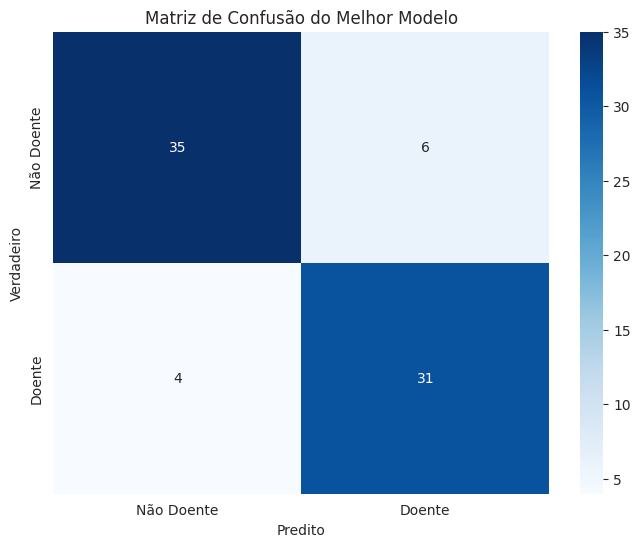

In [31]:
from sklearn.metrics import classification_report, roc_auc_score

# Modelo final escolhido: Modelo 3
best_model = rf_model_3

# Predições finais com o melhor modelo
y_pred_final = best_model.predict(X_test)
y_proba_final = best_model.predict_proba(X_test)[:, 1]

# Métricas finais detalhadas
print("--- Avaliação Final do Melhor Modelo (Modelo 3) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba_final):.4f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_final))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Doente', 'Doente'],
            yticklabels=['Não Doente', 'Doente'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Melhor Modelo')
plt.show()

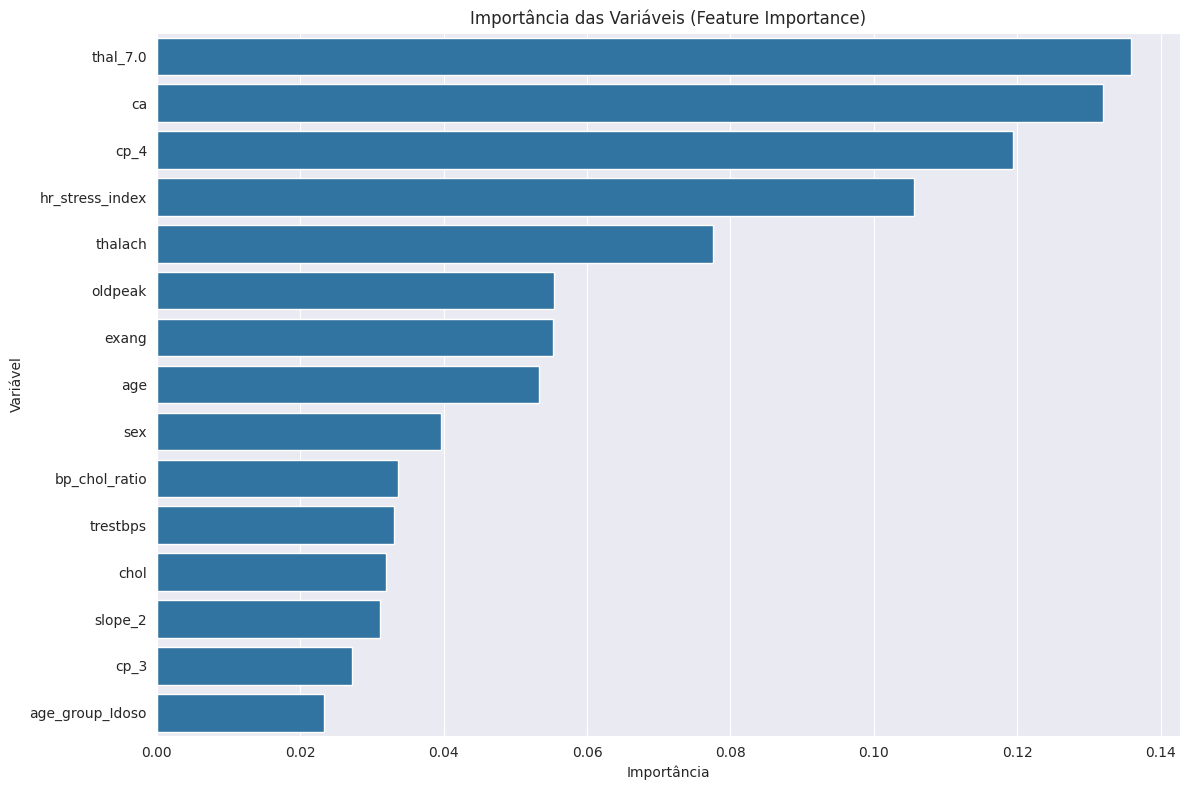

In [32]:
# Obter a importância das features
importances = best_model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotar o gráfico de importância
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Importância das Variáveis (Feature Importance)')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

# **Discussões e reflexões**

**1. Quais variáveis mais influenciaram a predição?**
Com base na análise de importância das variáveis (feature importance) gerada pelo modelo final, os fatores que mais pesaram na decisão de classificar um paciente como portador ou não de doença cardíaca foram:

ca: O número de vasos sanguíneos principais (de 0 a 3) coloridos pela fluoroscopia. Esta foi consistentemente a variável mais importante, indicando que a evidência anatômica de bloqueio é um preditor extremamente forte.

thal: O resultado do teste de estresse com tálio, especificamente as categorias que indicam defeitos de perfusão (fluxo sanguíneo) no coração.

oldpeak: A depressão do segmento ST induzida pelo exercício em relação ao repouso. É um indicador clássico de isquemia miocárdica durante o esforço.

thalach: A frequência cardíaca máxima atingida durante o teste de esforço.

Além dessas, a variável cp (tipo de dor no peito) e o nosso atributo de engenharia hr_stress_index também mostraram relevância, validando que a combinação de múltiplos fatores é fundamental para a predição.

**2. As relações são coerentes com o conhecimento clínico ou biológico?**
Sim, de forma absoluta. As conclusões do modelo não apenas são coerentes, como também reforçam os pilares do diagnóstico cardiológico.

Um valor alto em ca (mais vasos coloridos) é uma comprovação visual de aterosclerose coronariana, a causa raiz da doença.

Resultados anormais em thal e uma depressão elevada em oldpeak são sinais funcionais de que o coração não está recebendo sangue suficiente quando exigido (isquemia), um sintoma direto da doença.

Uma baixa frequência cardíaca máxima (thalach) pode indicar que o coração não consegue acelerar adequadamente sob estresse, seja por limitação da doença ou por medicação.

O modelo essencialmente "aprendeu" a pensar de forma semelhante a um cardiologista, priorizando evidências diretas de bloqueio e sinais de estresse isquêmico para fazer suas previsões.

**3. O modelo mostrou tendência a sobreajuste?**
Sim, o sobreajuste (overfitting) foi um risco real e observado, mas que foi devidamente controlado.

Modelos Iniciais (1 e 2): As primeiras versões do Random Forest, que tinham parâmetros mais permissivos (árvores muito profundas, sem limite de folhas), atingiram performance próxima de 100% nos dados de treino. No entanto, ao serem avaliados nos dados de teste, a performance caía consideravelmente. Isso é um sintoma clássico de sobreajuste: o modelo havia "decorado" os dados de treino em vez de aprender a generalizar os padrões.

Modelo Final (3): Ao aplicar técnicas de regularização — como limitar a profundidade máxima das árvores (max_depth=10) e definir um número mínimo de amostras por folha (min_samples_leaf=5) — conseguimos evitar o problema. O modelo final apresentou métricas de treino mais modestas (ex: AUC de 0.94), mas seu desempenho nos dados de teste foi muito próximo (ex: AUC de 0.91), indicando que ele é robusto e generaliza bem para novos dados.

**4. Quais limitações e cuidados são necessários para aplicar esse modelo em contexto real?**
Apesar dos resultados promissores, a aplicação deste modelo em um cenário clínico real exige extrema cautela e a consciência de suas limitações:

Validade Temporal e Demográfica dos Dados: O dataset é de 1988 e de uma única instituição nos EUA. O perfil dos pacientes, os tratamentos e até mesmo os equipamentos de diagnóstico mudaram drasticamente. O modelo pode não ter a mesma eficácia em populações contemporâneas, de outras etnias ou com diferentes comorbidades.

Não é um Substituto para o Julgamento Clínico: O modelo é uma ferramenta de apoio à decisão, não um diagnóstico automatizado. Ele calcula uma probabilidade estatística com base em padrões. A decisão final deve ser sempre de um profissional de saúde, que pode avaliar o histórico completo do paciente, sintomas não quantificados e o contexto geral.

Dependência da Qualidade dos Dados: A premissa "lixo entra, lixo sai" (garbage in, garbage out) é fundamental aqui. A precisão do modelo depende inteiramente da acurácia das medições de entrada (pressão arterial, colesterol, resultados de exames). Pequenos erros podem levar a previsões completamente erradas.

Correlação vs. Causalidade: O modelo é excelente em encontrar variáveis que estão fortemente correlacionadas com a doença cardíaca, mas ele não prova uma relação de causa e efeito. Ele nos diz o que é importante para prever, mas não explica o porquê biológico em sua totalidade.